# Image Deblurring with DnCNN

We built a feed-forward denoising convolutional neural network (DnCNN) to handle Gaussian noise. After getting informed about the state of the art in this field, we found out that DnCNNs should be very effective in handling several 
image denoising tasks. Moreover, Rectifier Linear Unit (ReLU), Residual Learning, and Batch Normalization allow to speed up the
training process as well as to improve the denoising performance. <br>
The proposed DnCNN is designed to predict the **residual image** *v*, i.e., the difference $$ v = y - x $$ where *y* is  the **noisy observation** (the input of our DnCNN) and  *x* is the latent **clean image**. In particular, the model should learn the **residual mapping** *R(y)*, i.e., the function that maps the noisy observation *y* into the residual image *R(y*). The mapping *R(y)* should make the difference between the noisy observation *y* and the residual image itself *R(y*) as close as possible to the clean image *x*, i.e.,
$$ y - R(y) ∼ x. $$




## Import libraries


In [2]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import *
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt

## Load and prepare the dataset


We download the dataset `data` using the provided function `getDataset`, that  loads and normalizes the CIFAR10 dataset. Moreover, the function adds Gaussian Blur (through `cv2.GaussianBlur`) and Gaussian noise (through `random.normal` and `random.random`) to the images of the dataset. We defined the training and test set `x_train` and `x_test` as the set of noisy images and the sets `y_train` and `y_test` as the corresponding labels, i.e., the original and clean images. 


In [3]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

#load the dataset
data = getDataset()

#defining the training and test set
x_train = data[0][0]
y_train = data[0][1]
x_test = data[1][0]
y_test = data[1][1]



170508288/170498071 [==============================] - 15s 0us/step


## Visualize the data
We show some images from the training set. We report some noise images (from `x_train`) in the bottom row, and the respective labels (from `y_train`) in the top row.


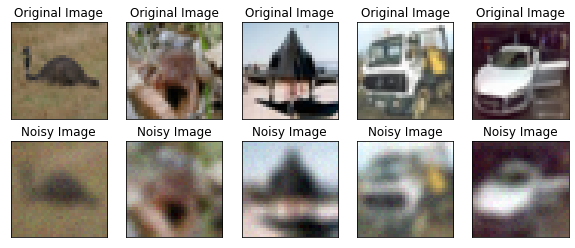

In [4]:
n = 5 #number of images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(10, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_train[idx].reshape(32, 32, 3), vmin = 0, vmax=255)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original Image')
    # display noisy image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train[idx].reshape(32, 32, 3), vmin = 0, vmax=255)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Noisy Image')
plt.show()


## Define the DnCNN model


### Batch Normalization

We decided to use  Batch Normalization because the training efficiency of Mini-batch stochastic gradient descent
is largely reduced by internal covariate
shift, i.e., changes in the distributions of internal nonlinearity
inputs during training. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. For further information, see  [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://proceedings.mlr.press/v37/ioffe15.html://))



### Residual Learning
Residual learning is adopted to separate noise from noisy observation. The model predicts the residual
image by gradually removing the latent clean image in the
hidden layers. It turns out that  the integration of Batch Normalization and Residual Learning speeds up
the training process as well as boosts the denoising performance.



### The network structure
The network contains different types of layers:
*  **Conv+ReLU** for the first layers: 64 filters
of size 3 x 3 x 3 are used to generate 64 feature maps, and
rectified linear units are then utilized for
nonlinearity;
* **Conv+BN+ReLU** for the middle layers: 64 filters of size
3 x 3 x 64 are used, and batch normalization is added
between convolution and ReLU;
* **Conv** for the next-to-last layer: 3 filters of size 3 x 3 x 64 are used to reconstruct the output;
* **Subtract** for the last layer.

The input of the network is the noisy observation *y*. The residual learning formulation is adopted to learn the mapping *R(y) = x*. Through the last layer the model subtracts the predicted residual image to the input of the network.
Accordingly, the output of the network is the denoised image, that should be as close as possible to the original clean image. Batch normalization is incorporated to speed up training as
well as boost the denoising performance, while, by incorporating
convolution with ReLU, DnCNN can gradually separate image
structure from the noisy observation through the hidden layers.






### Tuning of Hyperparameters 



* **Depth of the network**: High noise level usually requires larger effective patch size to capture more context information for restoration. Accordingly, the noise level should influence the choice on the dimension of the receptive field, and consequently on the depth of the network. As in this case the noise level is not so high (with respect to the noise levels considered in the paper), we believed it was unnecessary to use a lot of middle layers. Then, we used only 10 middle layers.

*   **Number of epochs**: The loss function reaches a low value (about 0.0028) after few epochs. However, with more epochs, it keeps decreasing until 0.0023 without overfitting the data. Thus, we decided to train the model for 40 epochs. 

*   **Learning Rate** and **number of features maps**: after some attempts, we considered that the best value for the learning rate was 1e-4. Moreover, we followed the paper about the decision of the number of features maps (set to 64).




In [5]:
#define the model
input = Input(shape=(32,32,3),name='input')

x = Conv2D(64,kernel_size= (3,3), padding='same',name='conv_l1')(input)
x = Activation('relu',name='act_l1')(x)
for i in range(10):
    x = Conv2D(64, kernel_size=(3,3), padding='same',  name='conv2d_'+str(i))(x)
    x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
    x = Activation('relu',name='act_'+str(i))(x)   
x = Conv2D(3, kernel_size=(3,3), padding='same',  name='conv_l3')(x)
x = Subtract(name='subtract')([input, x])   

model = tf.keras.Model(input,x)

#print the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_l1 (Conv2D)               (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 act_l1 (Activation)            (None, 32, 32, 64)   0           ['conv_l1[0][0]']                
                                                                                                  
 conv2d_0 (Conv2D)              (None, 32, 32, 64)   36928       ['act_l1[0][0]']                 
                                                                                              

### Save weights
We load the weights of the model in the following [folder](https://liveunibo-my.sharepoint.com/:f:/g/personal/anna_valanzano_studio_unibo_it/Es0YXMDYIYhJhQaJJuu_43MBNtju1gJBBGJ9J8MsDKvxEw?e=RHfsCK).

In [ ]:
#save the weights
model.save_weights("weights", save_format = "h5")

## Loss function

We have already explain that model should predict the residual image *R(y)* to make the difference between the noisy observation *y* and the residual image itself *R(y*) as close as possible to the clean image *x*. Thus, as the loss function should depend on the difference between the desired residual image and the estimated one, we thought the most suitable loss function was the MSE (**Mean Square Error**). Given the desired image *f* and the estimated one *g* (both of dimension *N*), the MSE is defined as 
$$ MSE(f, g) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N  \Vert f(i,j) - g(i,j) \Vert ^2 .$$ 




## Metric

The metric function encodes the difference between the desired  residual image and the estimated one. We thought the most suitable metric was the PSNR (peak signal-to-noise ratio), that is the most used metric to measure the quality of image obtained out of noise compression. Given a ground truth image (g) and noisy image (f), PSNR is defined as 
$$
PSNR(f,g) = 20 \cdot log  \left( \frac{MAX}{ \sqrt {MSE(f,g)}} \right)
$$
where MAX is the maximum value of the pixels in the images and MSE is the Mean Square Error. While the MSE must be minimized, the PSNR must be maximized. Indeed, the more the two images are similar, the more the PSNR is high.  


In [12]:
# define the PSNR metric
def PSNR(a, b, max_value=1):
   return tf.image.psnr(a, b, max_value)

sum=0;
for i in range(x_train.shape[0]):
  sum += PSNR(x_train[i], y_train[i])

print("Average PSNR before training", float(sum/x_train.shape[0]))

Average PSNR before training 22.365232467651367


## Compile the model


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="mse",
                  metrics=[PSNR])

## Train the model
During the training the loss function decreases, while the PSNR metric increases. 

In [ ]:
history = model.fit(x_train, y_train,
          batch_size = 16,
          epochs = 40,
          shuffle= True,
          validation_split = 0.15,
          verbose=1)

## Evaluate the model
We evaluate the performance of our model on the test set. 

In [ ]:
# Compute the loss and the PSNR on the test set.
results = model.evaluate(x_test, y_test)
print("Loss on the test test", results[0])
print("PSNR on the test test", results[1])


313/313 [==============================] - 2s 7ms/step - loss: 0.0023 - PSNR: 26.8069
Loss on the test test 0.002347163623198867
PSNR on the test test 26.806943893432617


## Inspect the results


In [ ]:
import matplotlib.pyplot as plt

def display_history(history):    
    mse_training = history.history['loss'] 
    acc_training = history.history['PSNR']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_PSNR']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('PSNR during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

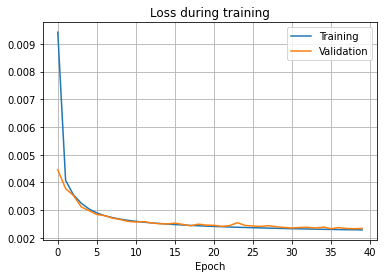

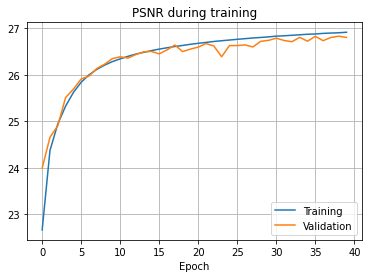

In [ ]:
display_history(history)

In the plots above, both the training and the validation performances increases over epochs and there is no evident difference between training and validation PSNR. Therefore, the model does not seem to overfit the data. 

### Show some denoised image

In [ ]:
denoised_imgs = model.predict(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


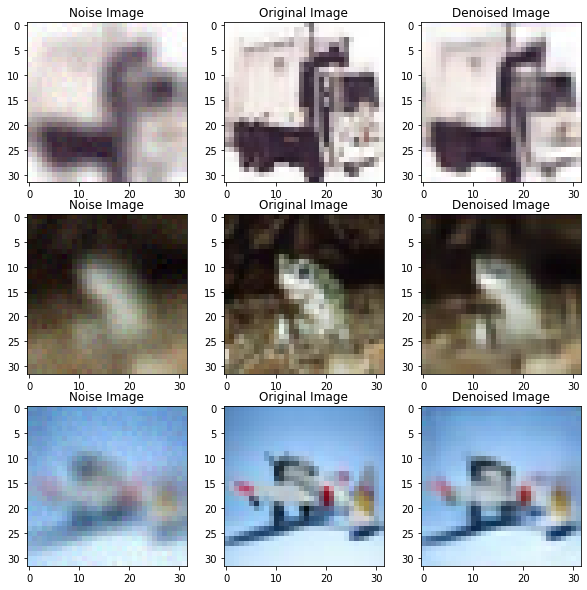

In [ ]:
n = 3 #number of images to plot
imgs = np.random.randint(low=0,high=10000,size=n)

fig, axes = plt.subplots(n, 3, figsize=(10,10))

for (i,idx) in enumerate(imgs):
    ax1, ax2, ax3 = axes[i]
    ax1.imshow(x_test[idx].reshape(32, 32,3), vmin = 0, vmax=255)
    ax1.set_title('Noise Image')
    ax2.imshow(y_test[idx].reshape(32, 32,3), vmin = 0, vmax=255)
    ax2.set_title('Original Image')
    ax3.imshow(denoised_imgs[idx].reshape(32, 32,3), vmin = 0, vmax=255)
    ax3.set_title('Denoised Image')
plt.show()

### Compute the PSNR
We compute the PSNR metric between the original image and the noisy image, and between the original image and the denoised image. As the denoised image should be closer to the original one than the noisy image, we expect that the second PSNR is higher.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


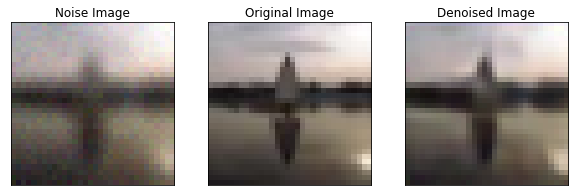

PSNR between the original image and the noisy image : 73.212265
PSNR between the original image and the denoised image: 78.008003


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
idx = np.random.randint(low=0,high=10000)
# display the noise image
axes[0].imshow(x_test[idx].reshape(32, 32,3), vmin = 0, vmax=255)
axes[0].set_title('Noise Image')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
# display the original image
axes[1].imshow(y_test[idx].reshape(32, 32,3), vmin = 0, vmax=255)
axes[1].set_title('Original Image')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].imshow(denoised_imgs[idx].reshape(32, 32,3), vmin = 0, vmax=255)
# display the denoised image
axes[2].set_title('Denoised Image')
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
plt.show()
#print the PSNR  between the original image and the noisy image
print('PSNR between the original image and the noisy image : %f' % tf.image.psnr(x_test[idx], y_test[idx], 255))
#print the PSNR  between the original image and the denoised image.
print("PSNR between the original image and the denoised image: %f" % tf.image.psnr(denoised_imgs[idx], y_test[idx], 255))

  